# Read a Veg Plot

In [1]:
from os import path
import s3fs
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
s3 = s3fs.S3FileSystem(anon=False)
files = s3.ls('bioscape-data/')
files

['bioscape-data/AVNG',
 'bioscape-data/BioSCapeVegPolys2023_10_18',
 'bioscape-data/BioSCapeVegPolys2023_10_18.parquet',
 'bioscape-data/LVIS',
 'bioscape-data/PRISM',
 'bioscape-data/bioscape_avng.yaml']

In [3]:
vegpoly_gdf = gpd.read_parquet(path.join('s3://', 'bioscape-data/BioSCapeVegPolys2023_10_18.parquet'))
vegpoly_gdf[:1]

,BScpPID,Region,Name,Dscrptn,DateTim,data_path,geometry
0,T171,Cederberg,Cederberg 171 polygon,None,03 May 2023 at 13:12:34,[s3://bioscape-data/BioSCapeVegPolys2023_10_18...,"MULTIPOLYGON (((19.02606 -32.15087, 19.02607 -..."


<Axes: >

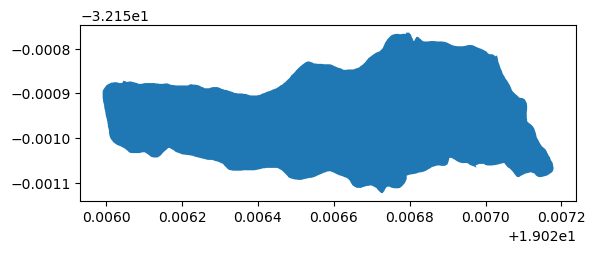

In [4]:
vegpoly_gdf[:1].plot()

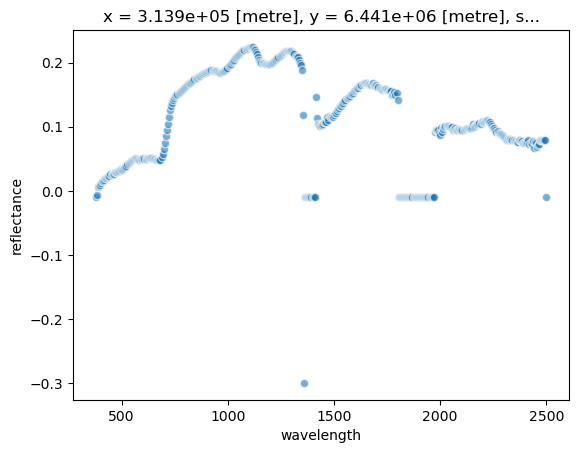

In [5]:
# plot AVIRIS-NG spectra of a pixel
with s3.open(vegpoly_gdf[:1]['data_path'][0][1]) as infile:
    ds = xr.open_dataset(infile, engine='h5netcdf', decode_coords="all")
    ds.isel(y=5, x=5).plot.scatter(y = 'reflectance', x='wavelength', alpha=0.6)
    plt.show()